# Prepare data

In [4]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from tqdm import tqdm
import json

from hpsklearn import HyperoptEstimator

General notes
- Glove good
- hyperopt sus


In [5]:
pheme = pd.read_csv('datasets/pheme.csv')
politifact = pd.read_csv('datasets/politifact.csv')
twitter = pd.read_csv('datasets/twitter.csv')
twitter15 = pd.read_csv('datasets/twitter15.csv')
twitter16 = pd.read_csv('datasets/twitter16.csv')

In [6]:
# glove twitter

nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])
print(X.shape)
X_t15 = np.array([nlp(text).vector for text in twitter15['text']])
X_t16 = np.array([nlp(text).vector for text in twitter16['text']])
print(X_t15.shape)
print(X_t16.shape)


#maybe try gensim? or stick with glove idk

(2402, 200)
(1490, 200)
(818, 200)


In [354]:
#pheme['e_text'] = X.tolist()
#pheme['rank'] = pheme['followers'].rank()
#pheme['group'] = np.array([int(x/(len(pheme)/5)) for x in pheme['rank']])


In [9]:
twitter15['glove'] = X_t15.tolist()
twitter16['glove'] = X_t16.tolist()
pheme['glove'] = X.tolist()
twitter15.rename(columns = {'verdict':'target'}, inplace = True)
twitter16.rename(columns = {'verdict':'target'}, inplace = True)

In [61]:
# Dataset Analysis with stemmed datasets
T15_TXT = ""
for index, line in twitter15.iterrows():
    T15_TXT = T15_TXT + line['text'] + " "
    # print(line)

T16_TXT = ""
for index, line in twitter16.iterrows():
    T16_TXT = T16_TXT + line['text'] + " "
    # print(line)

PHEME_TXT = ""

for index, line in pheme.iterrows():
    PHEME_TXT = PHEME_TXT + line['text'] + " "
    # print(line)

#print(T15_TXT)
#print(T16_TXT)
#print(PHEME_TXT)
CountVectors = CountVectorizer().fit_transform([T15_TXT, T16_TXT, PHEME_TXT]).toarray()
print(cosine_similarity([CountVectors[1, :], CountVectors[2, :]]))


#cosine_similarity()

[[1.         0.58475187]
 [0.58475187 1.        ]]


In [11]:
#pheme_train = pheme.drop('target', axis=1)
# X_tr, X_te, y_train, y_test = train_test_split(pheme_train, pheme['target'], test_size = 0.25, random_state = 42)
# X_train = np.array([text for text in X_tr['e_text']])
# X_test = np.array([text for text in X_te['e_text']])
dataset1 = twitter16
dataset2 = twitter15

train_X, _, train_y, __ = train_test_split(dataset1['glove'], dataset1['target'], test_size = 0.25, random_state = 42)
_, test_X, __, test_y = train_test_split(dataset2['glove'], dataset2['target'], test_size = 0.25, random_state = 42)

print(train_X)

181    [-0.0021383303683251143, 0.111158587038517, -0...
705    [-0.16097000241279602, -0.5138999819755554, -0...
633    [-0.04431845620274544, 0.14434652030467987, -0...
275    [0.13856640458106995, -0.018436841666698456, -...
158    [-0.012775163166224957, 0.018644684925675392, ...
                             ...                        
71     [0.11821100115776062, -0.44892627000808716, -0...
106    [0.11769477277994156, -0.25377213954925537, -0...
270    [-0.1842142641544342, -0.05317457765340805, 0....
435    [-0.2206292301416397, -0.10736429691314697, 0....
102    [-0.007166670169681311, -0.026617025956511497,...
Name: glove, Length: 613, dtype: object


In [12]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [15]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

text = twitter15['text'][0]
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

OSError: Can't load tokenizer for 'cardiffnlp/twitter-roberta-base-sentiment'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'cardiffnlp/twitter-roberta-base-sentiment' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.

In [24]:
record = [0, 0, 0]
for text in pheme['text']:

    # text = twitter15['text'][1]
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    record[np.argmax(scores)] += 1

print(record)

[468, 1917, 17]


In [56]:
from numpy import dot
from numpy.linalg import norm
import math

T15_SENTIMENT = [355 / 1, 1096 / 1, 39 / 1]
T16_SENTIMENT = [154 / 1, 630 / 1, 34 / 1]
PHEME_SENTIMENT = [568 / 1, 1917 / 1, 17 / 1]

a = T15_SENTIMENT
b = T16_SENTIMENT
c = PHEME_SENTIMENT
cos_sim = dot(a, b)/(norm(a)*norm(b))
eucl_dist = math.dist(a, c)

print(cos_sim)

cos_sim = dot(a, c)/(norm(a)*norm(c))
print(cos_sim)

cos_sim = dot(b, c)/(norm(b)*norm(c))
print(cos_sim)

print(T15_SENTIMENT)
print(T16_SENTIMENT)
print(PHEME_SENTIMENT)

0.9971336600833496
0.9993620803740608
0.9978725045409813
[355.0, 1096.0, 39.0]
[154.0, 630.0, 34.0]
[568.0, 1917.0, 17.0]


In [43]:
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import expit

MODEL = f"cardiffnlp/tweet-topic-21-multi"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
class_mapping = model.config.id2label

In [55]:
TOPICS = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for text in pheme['text']:

    # text = twitter15["text"][
    tokens = tokenizer(text, return_tensors='pt')
    output = model(**tokens)

    scores = output[0][0].detach().numpy()
    scores = expit(scores)
    # predictions = (scores >= 0.3) * 1

    #for i in range(len(predictions)):
    #    if predictions[i]:
    #        print(class_mapping[i])
    TOPICS[np.argmax(scores)] += 1
print(TOPICS)



[62, 5, 98, 194, 1, 16, 126, 3, 42, 2, 6, 151, 1568, 9, 7, 3, 66, 42, 1]


In [58]:
T15_TOPICS = [26, 35, 155, 111, 2, 9, 92, 10, 50, 8, 16, 31, 18, 3, 37, 74, 20]
T16_TOPICS = [13, 22, 50, 79, 1, 8, 48, 5, 30, 0, 5, 18, 14, 13, 7, 47, 15]
PHEME_TOPICS = [62, 5, 98, 194, 1, 16, 126, 3, 42, 2, 6, 151, 9, 7, 3, 66, 42]

a = T15_TOPICS
b = T16_TOPICS
c = PHEME_TOPICS
cos_sim = dot(a, b)/(norm(a)*norm(b))

print(cos_sim)

cos_sim = dot(a, c)/(norm(a)*norm(c))
print(cos_sim)

cos_sim = dot(b, c)/(norm(b)*norm(c))
print(cos_sim)

0.9412535786224928
0.8358224807122016
0.894460161329851


# Run models

In [361]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [362]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [363]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=50,
                            trial_timeout=120)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [364]:
X_train = train_X.tolist()
y_train = train_y.tolist()
X_test = test_X.tolist()
y_test = test_y.tolist()

In [365]:
# SVM
from hpsklearn import svc 
svm = optimize_model(svc("mySVC", probability=True), X_train, y_train)

100%|██████████| 50/50 [00:00<00:00,  1.76trial/s, best loss: 0.12195121951219512]
{'learner': SVC(C=1.230997542162419, coef0=0.30305872369058706,
    decision_function_shape='ovo', degree=4, kernel='linear', probability=True,
    random_state=4, tol=1.1436914984784e-05), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 73.46 %
F1: 66.7 %


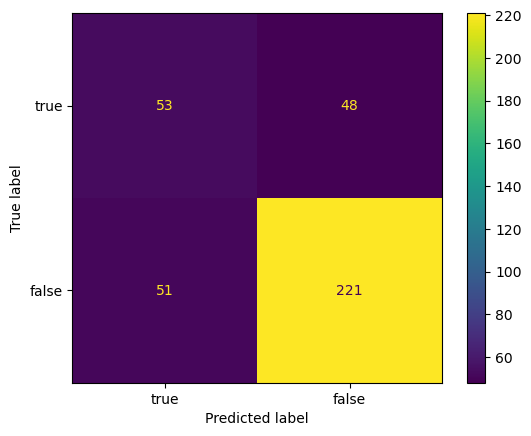

In [366]:
evaluate_model(svm, X_test, y_test)

In [367]:
# KNN
from hpsklearn import k_neighbors_classifier
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN"), X_train, y_train)

100%|██████████| 50/50 [00:00<00:00,  1.67trial/s, best loss: 0.12195121951219512]
{'learner': KNeighborsClassifier(algorithm='ball_tree', leaf_size=26, metric='l1', n_jobs=1,
                     n_neighbors=1, p=2.857908451531454), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 69.44 %
F1: 61.77 %


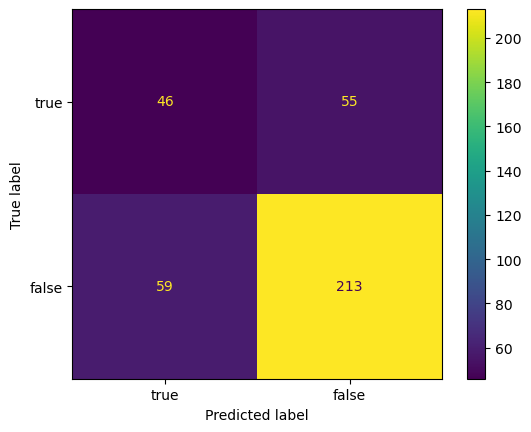

In [368]:
evaluate_model(knn, X_test, y_test)

In [369]:
# Logistic Regression logistic_regression
from hpsklearn import logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)
#print(X_train)

 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

job exception: unsupported operand type(s) for -: 'int' and 'NoneType'



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

Accuracy: 78.55 %
F1: 65.94 %


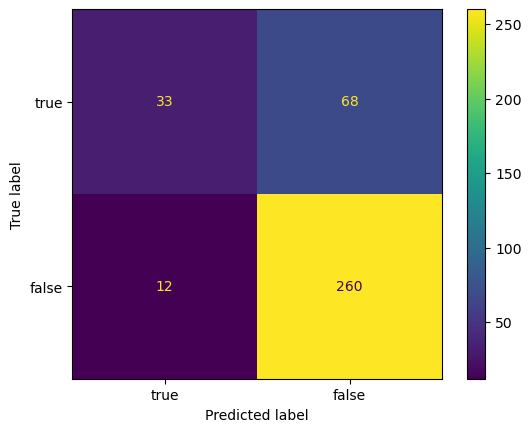

In [ ]:
evaluate_model(myLR, X_test, y_test)

In [ ]:
# AdaBoost

from hpsklearn import ada_boost_classifier, decision_tree_classifier
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", base_estimator=baseDT), X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 89%|████████▉ | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 91%|█████████ | 10/11 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 92%|█████████▏| 12/13 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 93%|█████████▎| 13/14 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 94%|█████████▍| 17/18 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 95%|█████████▍| 18/19 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 95%|█████████▌| 20/21 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 95%|█████████▌| 21/22 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 96%|█████████▌| 23/24 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 96%|█████████▌| 24/25 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 96%|█████████▋| 26/27 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 96%|█████████▋| 27/28 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 29/30 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 31/32 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 33/34 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 36/37 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 97%|█████████▋| 38/39 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 41/42 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 42/43 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 45/46 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 46/47 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


 98%|█████████▊| 49/50 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 50/50 [00:00<00:00,  1.85trial/s, best loss: 0.1651785714285714]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



{'learner': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         max_features='log2',
                                                         random_state=0),
                   learning_rate=0.060523848485681556, n_estimators=130,
                   random_state=4), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 76.41 %
F1: 60.43 %


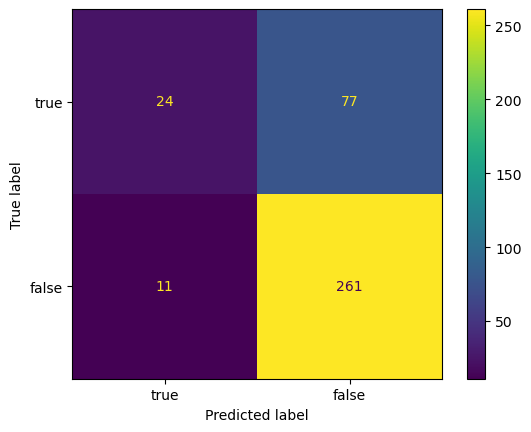

In [ ]:
# Run model with best results
evaluate_model(ada, X_test, y_test)

In [ ]:
from hpsklearn import mlp_classifier

mlp = optimize_model(mlp_classifier("mlp"), X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (163) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|█████████▌| 20/21 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (206) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|█████████▋| 35/36 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (184) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|█████████▊| 47/48 [00:00<?, ?trial/s, best loss=?]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (190) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 50/50 [00:00<00:00,  1.57trial/s, best loss: 0.1517857142857143]
{'learner': MLPClassifier(alpha=0.0035990682211844752, beta_1=0.8022389084321618,
              beta_2=0.9769084943118391, epsilon=6.556096796409453e-06,
              learning_rate='adaptive', learning_rate_init=0.014625158257149431,
              max_fun=20671, max_iter=221, momentum=0.8691585846918417,
              n_iter_no_change=30, power_t=0.6891140915266261, random_state=0,
              tol=0.0006487858743499091,
              validation_fraction=0.1719046392131692), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 83.11 %
F1: 76.1 %


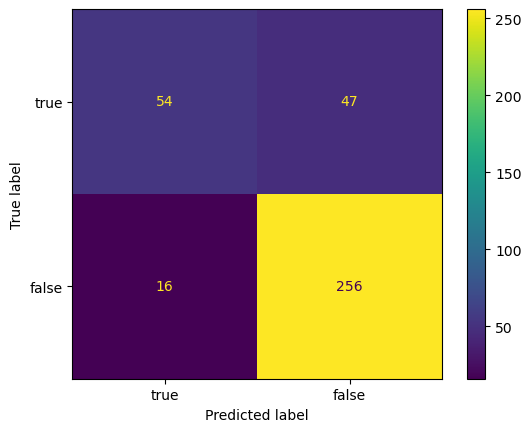

In [ ]:
evaluate_model(mlp, X_test, y_test)

# Clustering

In [ ]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#from sklearn.mixture import GaussianMixture

#n=25
#n_clusters = range(2, n+1)
#s_avgs = []

#for k in tqdm(n_clusters):
#    GM = GaussianMixture(n_components=k, n_init=10, random_state=5508)
#    cluster_labels = GM.fit_predict(X_train)

#    silhouette_avg = silhouette_score(X_train, cluster_labels, metric='euclidean')
#    s_avgs.append(silhouette_avg)

#fig, ax = plt.subplots()
#ax.set_xlim([1.5, n+0.5])

#ax = plt.plot(n_clusters, s_avgs, '-ok')
#plt.title("silhouette scores")
#plt.xlabel("K value")
#plt.ylabel("average silhouette score")
#plt.grid()
#plt.show()

In [ ]:
#from sklearn.mixture import GaussianMixture

#gm = GaussianMixture(n_components=24)
#gm_train_labels = gm.fit_predict(X_train)
#gm_test_labels = gm.predict(X_test)

## Ensemble

In [ ]:
sk_svm = svm.best_model()['learner']
sk_knn = knn.best_model()['learner']
sk_LR = myLR.best_model()['learner']
sk_ada = ada.best_model()['learner']
sk_mlp = mlp.best_model()['learner']

sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 78.82 %
F1: 65.08 %


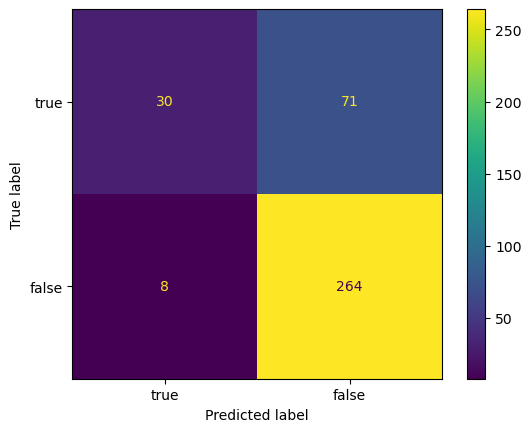

In [ ]:
# Hard voting
from sklearn.ensemble import VotingClassifier


names = ["svm", "LR", "ada", "mlp", "knn"]

hardvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="hard")
hardvoter.fit(X_train, y_train)
evaluate_model(hardvoter, X_test, y_test)

/Users/aij/miniconda3/envs/will/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 80.16 %
F1: 69.72 %


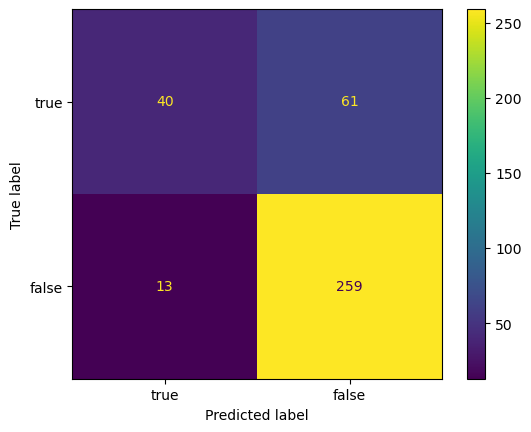

In [ ]:
softvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="soft")
softvoter.fit(X_train, y_train)
evaluate_model(softvoter, X_test, y_test)

In [ ]:
#from deslib.des import KNORAE

#e_ensemble = KNORAE(pool_classifiers=sk_classifiers)

#e_ensemble.fit(X_train, y_train)
#evaluate_model(e_ensemble, X_test, y_test)

In [ ]:
#e_ensemble_soft = KNORAE(pool_classifiers=sk_classifiers, voting="soft")
#e_ensemble_soft.fit(X_train, y_train)
#evaluate_model(e_ensemble_soft, X_test, y_test)

In [ ]:
#from deslib.des import KNORAU

#u_ensemble_hard = KNORAU(pool_classifiers=sk_classifiers, knn_metric = "mahalanobis")

#u_ensemble_hard.fit(X_train, y_train)
#evaluate_model(u_ensemble_hard, X_test, y_test)

In [ ]:
#u_ensemble_soft = KNORAU(pool_classifiers=sk_classifiers, voting="soft")

#u_ensemble_soft.fit(X_train, y_train)
#evaluate_model(u_ensemble_soft, X_test, y_test)

# Custom model

In [ ]:
"""
def set_clusters(train_category_values, test_category_values):
    trained_points = {}
    for i in range(len(train_category_values)):
        if train_category_values[i] in trained_points:
            trained_points[train_category_values[i]].append(i)
        else:
            trained_points[train_category_values[i]] = [i]

    return trained_points, train_category_values, test_category_values


def predict_points(points, ensemble, train_cluster, test_cluster):
    trained_points, train_events, test_events = set_clusters(train_cluster, test_cluster)
    #print(trained_points)
    final_predictions = []
    marks = []
    for j in tqdm(range(len(points))):
        event = test_events[j]
        event_points = trained_points[event]
        model_predictions = []
        for model in ensemble:
            score = model.score(np.array([X_train[i] for i in event_points]), np.array([y_train.iloc[i] for i in event_points]))
            pred = model.predict(points[j].reshape(1,-1))
            model_predictions.append((score, pred[0]))
        mark = 0
        if j == len(points) -1:
            print(model_predictions)
        for score, pred in model_predictions:    
            if pred == True:
                mark += score
            else:
                mark -= score
        #print(mark)
        if (mark > 0):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        marks.append(model_predictions)
    return final_predictions, marks
"""

'\ndef set_clusters(train_category_values, test_category_values):\n    trained_points = {}\n    for i in range(len(train_category_values)):\n        if train_category_values[i] in trained_points:\n            trained_points[train_category_values[i]].append(i)\n        else:\n            trained_points[train_category_values[i]] = [i]\n\n    return trained_points, train_category_values, test_category_values\n\n\ndef predict_points(points, ensemble, train_cluster, test_cluster):\n    trained_points, train_events, test_events = set_clusters(train_cluster, test_cluster)\n    #print(trained_points)\n    final_predictions = []\n    marks = []\n    for j in tqdm(range(len(points))):\n        event = test_events[j]\n        event_points = trained_points[event]\n        model_predictions = []\n        for model in ensemble:\n            score = model.score(np.array([X_train[i] for i in event_points]), np.array([y_train.iloc[i] for i in event_points]))\n            pred = model.predict(points[j].

In [ ]:
"""
def predict_points_gcats(points, cat_dir, json_file):
    f = open(json_file)
    gcats = json.load(f)
    for j in tqdm(range(len(points))):
        data_id = X_te["Unnamed: 0"].iloc[j]
        cats = gcats[str(data_id)]
        event_points = trained_points[event]
        model_predictions = []
        for model in ensemble:
            score = model.score(np.array([X_train[i] for i in event_points]), np.array([y_train.iloc[i] for i in event_points]))
            pred = model.predict(points[j].reshape(1,-1))
            model_predictions.append((score, pred[0]))
        mark = 0
        if j == len(points) -1:
            print(model_predictions)
        for score, pred in model_predictions:    
            if pred == True:
                mark += score
            else:
                mark -= score
        #print(mark)
        if (mark > 0):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        marks.append(model_predictions)
    
"""

'\ndef predict_points_gcats(points, cat_dir, json_file):\n    f = open(json_file)\n    gcats = json.load(f)\n    for j in tqdm(range(len(points))):\n        data_id = X_te["Unnamed: 0"].iloc[j]\n        cats = gcats[str(data_id)]\n        event_points = trained_points[event]\n        model_predictions = []\n        for model in ensemble:\n            score = model.score(np.array([X_train[i] for i in event_points]), np.array([y_train.iloc[i] for i in event_points]))\n            pred = model.predict(points[j].reshape(1,-1))\n            model_predictions.append((score, pred[0]))\n        mark = 0\n        if j == len(points) -1:\n            print(model_predictions)\n        for score, pred in model_predictions:    \n            if pred == True:\n                mark += score\n            else:\n                mark -= score\n        #print(mark)\n        if (mark > 0):\n            final_predictions.append(True)\n        else:\n            final_predictions.append(False)\n        marks

In [ ]:
# predict_points_gcats(X_test[0:2], "pheme_cats", "pheme_categories.json")

In [ ]:
#X_te["Unnamed: 0"].iloc[0]

In [ ]:
"""
f = open("./pheme_categories.json")
gcats = json.load(f)

for i in gcats["0"]:
    print(i)
    print(gcats["0"][i])
"""

'\nf = open("./pheme_categories.json")\ngcats = json.load(f)\n\nfor i in gcats["0"]:\n    print(i)\n    print(gcats["0"][i])\n'

In [ ]:
"""
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    print("Accuracy:", float("{0:.2f}".format(acc*100)), "%")
    f1 = f1_score(test, pred, average="macro")
    print("F1:", float("{0:.2f}".format(f1*100)), "%")
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
"""

'\ndef check_score(test, pred):\n    acc = accuracy_score(test, pred)\n    print("Accuracy:", float("{0:.2f}".format(acc*100)), "%")\n    f1 = f1_score(test, pred, average="macro")\n    print("F1:", float("{0:.2f}".format(f1*100)), "%")\n    cm = confusion_matrix(test, pred)\n    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])\n    disp.plot()\n    plt.show() \n'

In [ ]:
"""
o, t, s = set_clusters(gm_train_labels, gm_test_labels)
print(o.keys())
for key in o:
    print(key, len(o[key]))
"""

'\no, t, s = set_clusters(gm_train_labels, gm_test_labels)\nprint(o.keys())\nfor key in o:\n    print(key, len(o[key]))\n'

In [ ]:
"""
def check_score_manual(a, b):
    num = 0
    den = 0
    data = zip(a,b)
    data = tuple(data)
    mark = []
    for i in range(len(data)):
        if data[i][0] == data[i][1]:
            num += 1
            den += 1
        else:
            den += 1
            mark.append((marks[i], i))
    return num/den, mark
"""

'\ndef check_score_manual(a, b):\n    num = 0\n    den = 0\n    data = zip(a,b)\n    data = tuple(data)\n    mark = []\n    for i in range(len(data)):\n        if data[i][0] == data[i][1]:\n            num += 1\n            den += 1\n        else:\n            den += 1\n            mark.append((marks[i], i))\n    return num/den, mark\n'

In [ ]:
"""
print("events")
pred1, marks1 = predict_points(X_test, sk_classifiers, X_tr['event'].values, X_te['event'].values)
a, amarks = check_score_manual(y_test, pred1)
print("verified")
pred2, marks2 = predict_points(X_test, sk_classifiers, X_tr['verified'].values, X_te['verified'].values)
b, bmarks = check_score_manual(y_test, pred2)
print("gm clusters")
pred3, marks3 = predict_points(X_test, sk_classifiers, gm_train_labels, gm_test_labels)
c, cmarks = check_score_manual(y_test, pred3)
"""

'\nprint("events")\npred1, marks1 = predict_points(X_test, sk_classifiers, X_tr[\'event\'].values, X_te[\'event\'].values)\na, amarks = check_score_manual(y_test, pred1)\nprint("verified")\npred2, marks2 = predict_points(X_test, sk_classifiers, X_tr[\'verified\'].values, X_te[\'verified\'].values)\nb, bmarks = check_score_manual(y_test, pred2)\nprint("gm clusters")\npred3, marks3 = predict_points(X_test, sk_classifiers, gm_train_labels, gm_test_labels)\nc, cmarks = check_score_manual(y_test, pred3)\n'

In [ ]:
"""
print("followers")
pheme['rank'] = pheme['followers'].rank()
pheme['group'] = np.array([int(x/(len(pheme)/5)) for x in pheme['rank']])
pred4, marks4 = predict_points(X_test, sk_classifiers, X_tr['group'].values, X_te['group'].values)
d, dmarks = check_score_manual(y_test, pred4)
"""

'\nprint("followers")\npheme[\'rank\'] = pheme[\'followers\'].rank()\npheme[\'group\'] = np.array([int(x/(len(pheme)/5)) for x in pheme[\'rank\']])\npred4, marks4 = predict_points(X_test, sk_classifiers, X_tr[\'group\'].values, X_te[\'group\'].values)\nd, dmarks = check_score_manual(y_test, pred4)\n'

In [ ]:
"""
a1,a2 = map(list,zip(*amarks))
b1,b2 = map(list,zip(*bmarks))
c1,c2 = map(list,zip(*cmarks))
"""

'\na1,a2 = map(list,zip(*amarks))\nb1,b2 = map(list,zip(*bmarks))\nc1,c2 = map(list,zip(*cmarks))\n'

In [ ]:
"""
d, dmarks = check_score_manual(y_test, pred4)
print(d)
d1,d2 = map(list,zip(*dmarks))
"""

'\nd, dmarks = check_score_manual(y_test, pred4)\nprint(d)\nd1,d2 = map(list,zip(*dmarks))\n'

In [ ]:
# np.subtract(d2,a2).shape

false alarm on the high score - accidentally trained some on full set
event score ~83
verified score ~83
event, verified, gm, all get the same ones wrong